In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#



# The Open Sleeve Dipole

One last concept for a broadband antenna is the "Open Sleeve Dipole", which consists of a standard dipole and an adjacent (isolated) parasitic element which is said to increase bandwidth.  The idea is described in the following documents, among others:

* Smith, D.K., Conboy, T. ["A Truly Broadband, Efficient Low-Band Dipole" ](https://www.arrl.org/files/file/Antenna%20Book%20Supplemental%20Files/23rd%20Edition/A%20Truly%20Broadband,%20Efficient%20Low-Band%20Dipole%20-%20W7ZZ%20and%20N6RY(1).pdf)
* Severns, R. ["A Wideband 80M Dipole"](https://rudys.typepad.com/ant/files/antenna_broadband_dipole.pdf)


In this notebook I'm going to try to optimize the parameters of the antenna described in the Smith/Conboy paper. As previously stated, I haven't built or tested an actual antenna so this should all be viewed with appropriate skepticism....

Thanks to the authors of the articles referenced above, and the authors of the Pymoo project for their excellent optimization library..



<img src="../Cad/Series_Section_Match_5.svg" alt="Drawing" style="width: 800px;"/>

In [11]:
from necutil import nec5_sim_stdio3,plot_vswr,trim_res_freq,find_vswr_bw, vswr
import numpy as np

#
# To start, let's take a look at the feedpoint Z of a dipole at the height mentioned in the paper (80 ft / 24.4 m)
#

AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
necstr = """CE Dipole
GW 1 10 0 0 24.4 0 {len} 24.4 0.000814
GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {fnum} 0 0 {flow} {fstep}
XQ 0
EN
"""

freq = 3.75
y_est = 142.646 / freq / 2                              # Estimated half-dipole length (m)
y = trim_res_freq(necstr, freq, y_est, tol=0.001)       # Trims antenna to resonance at 3.75 MHz
print(f'Half element length (m): {y:.2f}')

# Simulate design to see feedpoint impedances across band
res = nec5_sim_stdio3([necstr.format(len=y, fnum=9, flow=3.5, fstep=(4.0-3.5)/8)])
zs = res[0][0][0]         # freqs, zs
print(zs)


Half element length (m): 19.45
[[3.5, (74.708-113.94j)], [3.5625, (79.393-85.121j)], [3.625, (84.254-56.565j)], [3.6875, (89.292-28.241j)], [3.75, (94.509-0.11607j)], [3.8125, (99.905+27.841j)], [3.875, (105.48+55.662j)], [3.9375, (111.24+83.378j)], [4.0, (117.18+111.02j)]]


In [24]:

#
# This is the same base class used in the previous notebook, with the GPU stuff included
#


import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, rot_y, translate, make_cage_element, total_wire_len
from necutil import series_match_precompute, series_match_scan

import jax.numpy as jnp
from jax import grad, jit, vmap, device_put


@jit
def series_match_scan_jax(zr, A,B,C,D, z0):
    zt = (zr*A + B) / ((1j)*zr*C + D)                   # Transformed impedances for all segment length combinations
    refl_coef = jnp.abs((zt - z0) / (zt + z0))
    vswr = (1 + refl_coef) / (1 - refl_coef)
    max_vswr = jnp.max(vswr, axis=-1)

    idx = jnp.argmin(max_vswr)                          # Flat index
    a,b = jnp.unravel_index(idx, max_vswr.shape)        # Convert to original indices
    return jnp.array((a, b)), vswr[a,b], jnp.array([max_vswr[a,b]])




class DipoleSSMProblem(Problem):
    # n_var, n_obj, n_ieq_constraints       #variables (design parameters), #objectives, #inequality constraints
    # segs_per_m                            segments per meter when generating NEC cards
    # radius, z                             wire radius (m), height above ground (m)
    # f_min, f_max, f_num                   freq band of interest, #freq points within band
    # z0a, z0b                              impedances of series-section-matching TLs
    def __init__(self, n_var, n_obj, n_ieq_constr, segs_per_m, radius, f_min, f_max, z, f_num=9, z0a=50, z0b=75, **kwargs):
        super().__init__(n_var=n_var,
                         n_obj=n_obj,
                         n_ieq_constr=n_ieq_constr,
                         **kwargs)

        # Save some problem characteristics
        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC segments per meter 
        self.radius = radius            # Wire radius (m)

        # Precompute some arrays (speeds process of scanning for optimum matching network)
        A,B,C,D = series_match_precompute(zoa=z0a,zob=z0b,nfreq=f_num,flow=f_min,fhigh=f_max)

        # ******** Move arrays to GPU ********
        self.A = device_put(A)
        self.B = device_put(B)
        self.C = device_put(C)
        self.D = device_put(D)
        # ******** Move arrays to GPU ********


        # NEC5 design deck template
        # GX: mirror across xz plane
        # EX: feedpoint specified as tag=1, segment=1, near end (1)
        # GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 
    

    # Optimization algorithms call this entry point with a population of designs
    #   X       an array of design parameters of shape (population_size, number_of_variables)
    #   out     dictionary where we'll return our results
    def _evaluate(self, X, out, *args, **kwargs):

        # Write a custom _make_design() for your problem
        # Use the params in x to create the design as a list of numpy arrays (see details in '010_Wire_Antennas.ipynb')
        designs = [self._make_design(x) for x in X]                 # Make antenna designs based on params in X

        # Turns your design into an NEC deck using the template
        necdecks = [self.necpre + gen_nec5_str(d, self.segs_per_m, self.radius) + self.necpost for d in designs]     # Convert to NEC decks (strings)

        res = nec5_sim_stdio3(necdecks, timelimit=10000.0)          # Run the simulations

        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Scan for optimum series matching segment lengths (degrees) for each design
        # We're checking all lengths of [0, 180] degrees for both z0a, z0b segments
        # a_b = np.empty((zs.shape[0],2))
        # vswr_curves = np.empty(zs.shape)
        # max_vswr = np.empty((zs.shape[0],1))
        # for idx in range(zs.shape[0]):
        #     aopt,bopt,vswr_curve_opt,vswr_max_opt = series_match_scan(zs[idx:idx+1], self.A,self.B,self.C,self.D, z0=self.z0)
        #     a_b[idx,:] = (aopt,bopt)
        #     vswr_curves[idx,:] = vswr_curve_opt
        #     max_vswr[idx,:] = vswr_max_opt

        # ******** Runs the previous code block on the GPU ********
        # The 100 or 200 designs are evaluated in parallel...
        a_b,vswr_curves,max_vswr = vmap(series_match_scan_jax, (0,None,None,None,None,None))(zs, self.A,self.B,self.C,self.D, 50)
        # *********************************************************


        # Write a custom function to return objectives, constraints, other values
        self._compute_results(X, out, designs, zs, a_b, vswr_curves, max_vswr)


    

#
# We need to modify this stuff for the specific problem:
#
#  * single objective (minimize max VSWR in band)
#  * (3) variables:
#       active half-element length (m)
#       parasitic element length (as fraction of active el)
#       element separatiom (m)
#
class OpenSleeveSSMProblem(DipoleSSMProblem):
    def __init__(self, **kwargs):
        super().__init__(n_var=3, n_obj=1, n_ieq_constr=0, **kwargs)

    # Your custom function to construct the antenna
    # Design params: 
    #   x[0]    active half-el length 
    #   x[1]    parasitic el length (as fraction of active el)
    #   x[2]    separation
    def _make_design(self, x):
        half_el = make_linear_element((0,0,self.z),(0,x[0],self.z))                             # Active el (needs to be first)
        half_el.extend( make_linear_element((0,0,self.z+x[2]),(0,x[0]*x[1],self.z+x[2])) )      # Parasitic
        return half_el


    # Your custom function to return objectives, constraints, other values
    def _compute_results(self, X, out, designs, zs, a_b, vswr_curves, max_vswr):

        # Objective to minimize:  max vswr in band
        out['F'] = [max_vswr]         # Return objs as a list of column vectors
        
        # Can attach any other data to population of designs
        #  Not used in optimization, but can be examined later...
        out['VSWR'] = vswr_curves               # VSWR values across freq band
        out['AB'] = a_b                         # Lengths (degrees) of 'z0a' and 'z0b' matching sections
        


AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element
osproblem = OpenSleeveSSMProblem(f_min=3.5, f_max=4.0, z=24.4,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([17.0, 0.8, 0.3]),      # Active len [17, 23], parasitic [0.8, 1.0], spacing [0.3,3.0]
                                xu=np.array([23.0, 1.0, 3.0]))               
# Pymoo provides a variety of termination conditions
# For simplicity's sake we will just run for 50 generations
termination = get_termination("n_gen", 100)  

# Algorithm: Single-objective genetic algorithm
algorithm = GA(pop_size=200, n_offsprings=100)
# Run
res = minimize(osproblem, algorithm, termination, save_history=False, verbose=True)



n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      200 |           nan |           nan
     2 |      300 |  6.3931186789 |  1.2267756462
     3 |      400 |  2.8139980710 |  1.2267756462
     4 |      500 |  2.0480493164 |  1.2267756462
     5 |      600 |  1.7992123830 |  1.2267756462
     6 |      700 |  1.6672693729 |  1.2267756462
     7 |      800 |  1.5533209509 |  1.2267756462
     8 |      900 |  1.4551036894 |  1.2267756462
     9 |     1000 |  1.3908919352 |  1.2146995068
    10 |     1100 |  1.3397877318 |  1.2146995068
    11 |     1200 |  1.3034505594 |  1.2146995068
    12 |     1300 |  1.2791499579 |  1.2080883980
    13 |     1400 |  1.2653361142 |  1.1997630596
    14 |     1500 |  1.2518297595 |  1.1997630596
    15 |     1600 |  1.2398198354 |  1.1973206997
    16 |     1700 |  1.2318327749 |  1.1973206997
    17 |     1800 |  1.2239995122 |  1.1973206997
    18 |     1900 |  1.2193729645 |  1.1958515644
    19 |     2000 |  1.2162113500 |  1.1958515644


In [25]:
res.X

array([20.44074817,  0.88358665,  1.013811  ])

In [26]:
res.F

array([1.19447899])

In [27]:
res.pop.get('AB')

array([[180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,  91.],
       [180.,

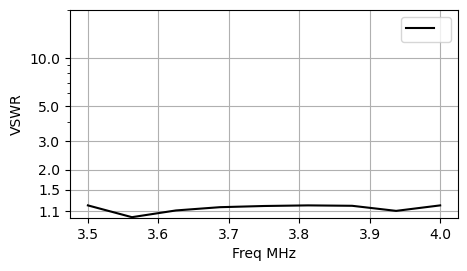

In [28]:
fvpairs = list(zip(osproblem.freqs, res.pop.get('VSWR')[0]))   # Combine frequencies and VSWR values
plot_vswr_2([fvpairs], tags=[f''])